In [10]:
import numpy as np
from numpy.random import multivariate_normal
import scipy as scp
import sklearn
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score as nmi
import matplotlib.pyplot as plt

N_SAMPLES = 1000

In [2]:
def get_synth_data():
    c1_means = [[1, 1],[1, 2],[1, 1]]
    c2_means = [[3, 4],[2, 2],[3, 3]]
    c1_cov = list()
    c1_cov.append([[1, 0.5],[0.5, 1.5]])
    c1_cov.append([[1, -0.2],[-0.2, 1]])
    c1_cov.append([[1.2, 0.2],[0.2, 1]])
    c2_cov = list()
    c2_cov.append([[0.3, 0.2],[0.2, 0.6]])
    c2_cov.append([[0.6, 0.1],[0.1, 0.5]])
    c2_cov.append([[1, 0.4],[0.4, 0.7]])
    means = [c1_means, c2_means]
    cov = [c1_cov, c2_cov]
    v_data =  [[],[],[]]
    
    for co in range(2):
        for vi in range(3):
            samples = multivariate_normal(means[co][vi], cov[co][vi], N_SAMPLES)
            v_data[vi].append(samples)
            
    for vi in range(3):
        v_data[vi] = np.vstack(v_data[vi])
    
    labels = np.concatenate((np.zeros((N_SAMPLES,)), np.ones((N_SAMPLES,))))
    
    shuffle_inds = np.random.permutation(N_SAMPLES * 2)
    for vi in range(3):
        v_data[vi] = v_data[vi][shuffle_inds]
    labels = labels[shuffle_inds]
    
    return v_data, labels

In [3]:
v_data, labels = get_synth_data()

In [4]:
def gaussian_sim(X_mat):
    
    samples = X_mat.shape[0]
    distances = list()
    for ind1 in range(samples):
        distances.append(np.linalg.norm(X_mat - X_mat[ind1].reshape(1, -1), axis = 1))
    distances = np.vstack(distances)
    sq_dists = np.square(distances)
    norm_dists = sq_dists / (2 * (np.median(sq_dists)))
    sims = np.exp(-norm_dists)
    
    return sims
    
def sym(S_mat):
    return (S_mat + np.transpose(S_mat))/2

def comp_laplacian(X_mat, k):
    D_mat = np.zeros((X_mat.shape[0], X_mat.shape[1]))
    for ind in range(X_mat.shape[0]):
        D_mat[ind, ind] = np.power(np.sum(X_mat[ind, :]), -0.5)
    laplacian = np.matmul(D_mat, X_mat)
    laplacian = np.matmul(laplacian, D_mat)
    return laplacian

def comp_eigs(X_mat, k):
    laplacian = comp_laplacian(X_mat, k)
    e_vals, e_vecs = np.linalg.eig(laplacian)
    indices = np.argsort(e_vals)[-k:]
    e_vecs = e_vecs[:,indices]
    return e_vecs

In [5]:
def multiview_spectral(v_data, labels, k=2, num_iter = 3):
    #Compute the similarities matrices
    similarities = [gaussian_sim(dat) for dat in v_data]
    sim_sums = [np.matmul(sim, np.transpose(sim)) for sim in similarities]
    total_sims = np.sum(np.array(sim_sums), axis=0)
    
    #Initialize matrices of eigenvectors
    U_mats = [comp_eigs(sim, k) for sim in similarities]
    
    #Iteratively compute new graph similarities, laplacians, and eigenvectors
    for iter in range(num_iter):
        print(iter)
        new_sims = list()
        for view in range(len(v_data)):
            mat = np.matmul(total_sims - sim_sums[view], similarities[view])
            new_sims.append(sym(mat))
            
        similarities = new_sims    
        sim_sums = [np.matmul(sim, np.transpose(sim)) for sim in similarities]
        total_sims = np.sum(np.array(sim_sums), axis=0)
        U_mats = [comp_eigs(sim, k) for sim in similarities]
            
    #Row normalize 
    for view in range(len(v_data)):
        U_mats[view] /= np.mean(U_mats[view], axis=1).reshape((-1, 1))
    #Columnwise concatenation across all views
    V_mat = np.hstack(U_mats)
        
    kmeans = KMeans(n_clusters=k)
    clusters = kmeans.fit_predict(V_mat)
    return clusters
    

In [6]:
clusters = multiview_spectral(v_data, labels)


0
1
2


C:\Users\Alexander\Anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)


In [7]:
score = nmi(labels, clusters)
print(score)

0.006350219292559339


In [8]:
print()
print(clusters.sum())


1


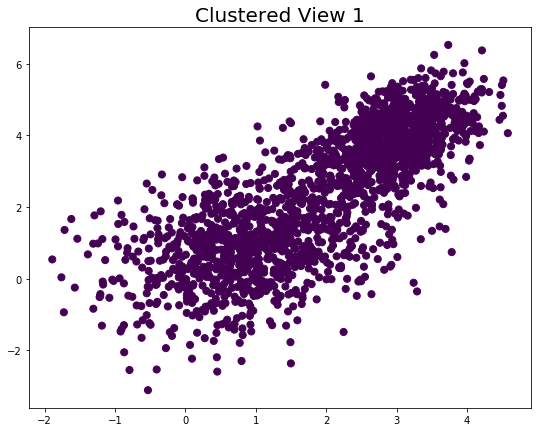

In [15]:
fig, ax = plt.subplots(figsize=(9,7))
cmap = 'viridis'
dot_size=50
ax.set_title('Multiview clusters View 1', size=20)
ax.scatter(v_data[0][:, 0], v_data[0][:, 1],c=clusters,s=dot_size, cmap=cmap)

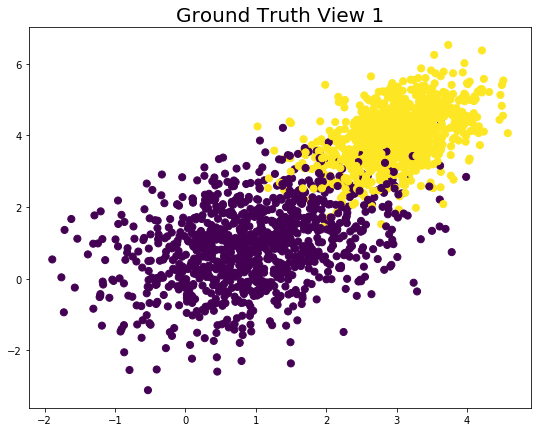

In [16]:
fig, ax = plt.subplots(figsize=(9,7))
cmap = 'viridis'
dot_size=50
ax.set_title('Ground Truth View 1', size=20)
ax.scatter(v_data[0][:, 0], v_data[0][:, 1],c=labels,s=dot_size, cmap=cmap)